In [348]:
strategy_name ='玉晶量化1号'

In [349]:
import sys
sys.path.append("C:\Program Files\Tinysoft\Analyse.NET")
sys.path.append(r"C:\Users\xudong\Documents\guanzhao\dataServer")
import pymongo
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import datetime
import copy
from funcs import *
import pandas as pd
from operator import itemgetter
import TSLPy3 as tsl
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import talib
import matplotlib.dates as mdates

np.set_printoptions(formatter={'float_kind': "{:.6f}".format})
client = pymongo.MongoClient('localhost', 27017)
db = client.quanLiang
dbt = client.tinySoftData

In [350]:
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1

In [347]:
startDate = 20200921
endDate = 20201026
q = list(dbt.minuteBar.find({'ticker':'IC2011', 'dateAsInt':{'$gte':startDate, '$lte':endDate}},{'dateTimeFloat':1, 'close':1, 'high':1, 'low':1}).sort('dateTimeFloat',1))
d0 = np.array([x['dateTimeFloat'] for x in q])
h0 = np.array([x['high'] for x in q])
l0 = np.array([x['low'] for x in q])
c0 = np.array([x['close'] for x in q])


In [308]:
toke = list(np.sort(list(set([int(np.round(1e4*(x-np.floor(x)))) for x in d0]))))
toke.append(931)
for (q,x) in enumerate(d0):
    m = int(np.round(1e4*(x-np.floor(x))))
    if (m==931):
        i0 = q
        break
i = i0
while (i<len(d0)-1):
    x = d0[i]
    m = int(np.round(1e4*(x-np.floor(x))))
    m2 = int(np.round(1e4*(d0[i+1]-np.floor(d0[i+1]))))
    if toke[toke.index(m)+1]!=m2:
        print(x,'后是：', d0[i+1],' 缺失', toke[toke.index(m)+1])
        d0=np.insert(d0, i+1, values=np.floor(d0[i])+toke[toke.index(m)+1]/1e4)
        h0=np.insert(h0, i+1, values=h0[i])
        l0=np.insert(l0, i+1, values=l0[i])
        c0=np.insert(c0, i+1, values=c0[i])
        print(x,'后添加:', np.floor(d0[i])+toke[toke.index(m)+1]/1e4)
    i = i+1
h0 =  pd.DataFrame(h0)
l0 =  pd.DataFrame(l0)
c0 =  pd.DataFrame(c0)

20200921.1009 后是： 20200921.1011  缺失 1010
20200921.1009 后添加: 20200921.101
20200921.1041 后是： 20200921.1043  缺失 1042
20200921.1041 后添加: 20200921.1042
20200921.1333 后是： 20200921.1335  缺失 1334
20200921.1333 后添加: 20200921.1334
20200921.1347 后是： 20200921.1349  缺失 1348
20200921.1347 后添加: 20200921.1348
20200921.1353 后是： 20200921.1355  缺失 1354
20200921.1353 后添加: 20200921.1354
20200921.1357 后是： 20200921.1359  缺失 1358
20200921.1357 后添加: 20200921.1358
20200921.1403 后是： 20200921.1405  缺失 1404
20200921.1403 后添加: 20200921.1404
20200921.1433 后是： 20200921.1435  缺失 1434
20200921.1433 后添加: 20200921.1434
20200922.1056 后是： 20200922.1058  缺失 1057
20200922.1056 后添加: 20200922.1057
20200922.1059 后是： 20200922.1101  缺失 1100
20200922.1059 后添加: 20200922.11
20200923.1016 后是： 20200923.1018  缺失 1017
20200923.1016 后添加: 20200923.1017
20200923.1029 后是： 20200923.1031  缺失 1030
20200923.1029 后添加: 20200923.103
20200923.1033 后是： 20200923.1035  缺失 1034
20200923.1033 后添加: 20200923.1034
20200923.1044 后是： 20200923.1046  缺失 1045
2

In [309]:
def resample(close_mtx, low_mtx, high_mtx, dtes, s=3):
    d = []
    h = []
    l = []
    c = []
    for x in range(s-1,len(d0),s):
        d.append(d0[x])
        h.append(np.max(h0[0][x-s+1:x+1]))
        l.append(np.min(l0[0][x-s+1:x+1]))
        c.append(c0[0][x])
    close_mtx =  pd.DataFrame(c)
    low_mtx   =  pd.DataFrame(l)
    high_mtx  =  pd.DataFrame(h)
    dtes = np.array(d)
    return close_mtx, low_mtx, high_mtx, dtes

close_mtx,low_mtx,high_mtx,dtes = resample(c0,l0,h0,d0,3)
c1,l1,h1,d1 = resample(c0,l0,h0,d0,60)




In [310]:
N = 3
M = 21
EMA_closeN1H = c1.ewm(span=N, min_periods=0, adjust=False, ignore_na=False).mean()

EMA_highM1H = h1.ewm(span=M, min_periods=0, adjust=False, ignore_na=False).mean()
EMA_lowM1H = l1.ewm(span=M, min_periods=0, adjust=False, ignore_na=False).mean()

EMA_highN1H = h1.ewm(span=N, min_periods=0, adjust=False, ignore_na=False).mean()
EMA_lowN1H = l1.ewm(span=N, min_periods=0, adjust=False, ignore_na=False).mean()

AMA_11H = pd.DataFrame(np.zeros(h1.shape))
AMA_21H = pd.DataFrame(np.zeros(h1.shape))

AMA_high1H = pd.DataFrame(np.zeros(h1.shape))
AMA_low1H = pd.DataFrame(np.zeros(h1.shape))

AMA1H = pd.DataFrame(np.zeros(h1.shape))

In [311]:
dif = c1.diff()
dif[0][0] = 0

for i in range(10, len(c1)):
    d  = np.abs(c1[0][i] - c1[0][i-10])
    v  = np.sum(np.abs(dif)[i-9:i+1])
    er = d/v
    sc = er*(2/3-2/31)+2/31
    ssc = sc*sc
    AMA_11H[0][i] = EMA_highM1H[0][i-1]  + ssc * (h1[0][i] - EMA_highM1H[0][i-1])
    AMA_21H[0][i] = EMA_lowM1H[0][i-1]   + ssc * (l1[0][i]  - EMA_lowM1H[0][i-1])
    #AMA_closeM[0][i] = EMA_closeM[0][i] + ssc * (close_mtx[0][i] - EMA_closeM[0][i])
    AMA_high1H[0][i] = EMA_highN1H[0][i-1] + ssc * (h1[0][i] - EMA_highN1H[0][i-1])
    AMA_low1H[0][i] = EMA_lowN1H[0][i-1] + ssc * (l1[0][i] - EMA_lowN1H[0][i-1])
    AMA1H[0][i] = (AMA_high1H[0][i]+AMA_low1H[0][i])/2
    print(d1[i],AMA1H[0][i], AMA_11H[0][i],AMA_21H[0][i])


20200923.14 6234.274861020529 6336.8203042212035 6272.786397398135
20200923.15 6239.0929786801735 6331.311705985768 6268.98792703892
20200924.103 6233.156364618415 6315.737664944557 6250.432130794838
20200924.113 6187.456698349408 6290.973303085813 6225.516988091201
20200924.14 6143.158564047272 6286.955907567432 6221.9337507636355
20200924.15 6120.552788853089 6264.991957769945 6200.843229005837
20200925.103 6117.436999445409 6264.887044518361 6201.29038464959
20200925.113 6122.689583269994 6254.098549760683 6191.4549293772025
20200925.14 6116.295702119707 6240.680508884335 6179.7896879808895
20200925.15 6109.692323554671 6232.107647728202 6171.929493195857
20200928.103 6110.417358238305 6222.187410275304 6161.227915124604
20200928.113 6114.1172758466855 6210.562024003909 6151.120438907823
20200928.14 6100.577212913643 6210.6203350918695 6150.837727072034
20200928.15 6098.559476556219 6204.13145683783 6143.983867374667
20200929.103 6090.294292827151 6194.951731888273 6135.609810898239

In [312]:
N = 3
M = 15
EMA_closeN = close_mtx.ewm(span=N, min_periods=0, adjust=False, ignore_na=False).mean()

EMA_highM = high_mtx.ewm(span=M, min_periods=0, adjust=False, ignore_na=False).mean()
EMA_lowM  =  low_mtx.ewm(span=M, min_periods=0, adjust=False, ignore_na=False).mean()

EMA_highN = high_mtx.ewm(span=N, min_periods=0, adjust=False, ignore_na=False).mean()
EMA_lowN  =  low_mtx.ewm(span=N, min_periods=0, adjust=False, ignore_na=False).mean()

AMA_1 = pd.DataFrame(np.zeros(high_mtx.shape))
AMA_2 = pd.DataFrame(np.zeros(high_mtx.shape))

AMA_high = pd.DataFrame(np.zeros(high_mtx.shape))
AMA_low = pd.DataFrame(np.zeros(high_mtx.shape))

AMA   = pd.DataFrame(np.zeros(high_mtx.shape))

In [313]:
def get_EMA(cps, days):
    emas = cps.copy()  # 创造一个和cps一样大小的集合
    for i in range(len(cps)):
        if i == 0:
            emas[i] = cps[i]
        if i > 0:
            emas[i] = ((days - 1) * emas[i - 1] + 2 * cps[i]) / (days + 1)
    return emas

In [314]:
#第一步：计算效率比ER（Efficiency Ratio）
#ER = 变化值/波动值变化值 = 当前价格与N周期前价格差值的绝对值
dif = close_mtx.diff()
dif[0][0] = 0
constant = 1

for i in range(10, len(close_mtx)):
    d  = np.abs(close_mtx[0][i] - close_mtx[0][i-10])
    v  = np.sum(np.abs(dif)[i-9:i+1])
    er = d/v
    sc = er*(2/3-2/31)+2/31
    ssc = sc*sc
    AMA_1[0][i] = EMA_highM[0][i-1]  + ssc * (high_mtx[0][i] - EMA_highM[0][i-1])
    AMA_2[0][i] = EMA_lowM[0][i-1]   + ssc * (low_mtx[0][i]  - EMA_lowM[0][i-1])
    #AMA_closeM[0][i] = EMA_closeM[0][i] + ssc * (close_mtx[0][i] - EMA_closeM[0][i])
    AMA_high[0][i] = EMA_highN[0][i-1] + ssc * (high_mtx[0][i] - EMA_highN[0][i-1])
    AMA_low[0][i] = EMA_lowN[0][i-1] + ssc * (low_mtx[0][i] - EMA_lowN[0][i-1])
    AMA[0][i] = (AMA_high[0][i]+AMA_low[0][i])/2
    print(dtes[i],AMA[0][i], AMA_1[0][i],AMA_2[0][i])


20200921.1003 6349.065118753217 6373.266101533795 6354.694700845548
20200921.1006 6348.749879268769 6371.990609768162 6354.217451548292
20200921.1009 6352.047695770998 6370.898497331986 6353.6209212107815
20200921.1012 6351.551167431939 6369.361716803945 6352.560906769578
20200921.1015 6349.939056183517 6367.328750486074 6351.485948264849
20200921.1018 6346.67853317333 6364.749294645804 6350.035707292035
20200921.1021 6343.917949459776 6362.297231681983 6348.477612010176
20200921.1024 6343.209709414104 6360.2247698908395 6347.044542292908
20200921.1027 6341.579769427488 6357.485642686856 6344.8169157450875
20200921.103 6337.294941849321 6355.993307920661 6343.664014845251
20200921.1033 6337.61890062815 6354.082584102943 6341.7399004061535
20200921.1036 6338.620785953072 6352.9778815141135 6340.826956619965
20200921.1039 6338.355050651437 6352.01587348268 6340.185719501826
20200921.1042 6340.146698788248 6351.371742040729 6339.549244517122
20200921.1045 6338.486705715912 6350.2127522838

20200922.1403 6255.868045915255 6271.284146683446 6261.930157273144
20200922.1406 6251.269290319115 6268.60703032046 6258.838963669356
20200922.1409 6247.514500682339 6265.056015735803 6255.277483411373
20200922.1412 6243.741830431126 6264.362738284111 6254.147089230704
20200922.1415 6239.639528593059 6261.773625713714 6251.9501946102355
20200922.1418 6239.982411631065 6257.712975150288 6247.609689377746
20200922.1421 6237.102974718373 6253.880195642302 6244.295124048401
20200922.1424 6232.522792266645 6250.4728469934025 6239.355441803996
20200922.1427 6229.452525448072 6249.900278713117 6239.547291785283
20200922.143 6225.744603117835 6247.417131970058 6236.536080632309
20200922.1433 6221.003450602051 6242.324746435429 6228.939193547183
20200922.1436 6213.941203022028 6240.847245999628 6226.2693319088885
20200922.1439 6211.179957708314 6236.629130055752 6222.688985376253
20200922.1442 6202.67131276038 6228.319365167084 6212.868460671465
20200922.1445 6196.415489957681 6224.94556368253

20200924.1103 6076.893618477407 6108.913539871308 6093.266534956709
20200924.1106 6070.525337331576 6102.139490534018 6087.331472844964
20200924.1109 6067.131354001944 6102.614873592524 6087.4647423374945
20200924.1112 6070.974658051119 6101.072450881935 6085.147802196438
20200924.1115 6083.5947508653535 6102.028802141607 6084.921773041967
20200924.1118 6087.33518729609 6101.295235792281 6084.795513235256
20200924.1121 6086.464190845079 6100.3383189920205 6084.094409172937
20200924.1124 6088.7719105729975 6100.092014423297 6083.646018722451
20200924.1127 6086.038933055639 6099.860391439964 6082.055898312446
20200924.113 6083.161755044735 6098.064331476047 6080.846537153408
20200924.1303 6082.5934706149965 6096.4379689136795 6080.470321536654
20200924.1306 6078.301644097828 6095.202854562183 6078.530048148783
20200924.1309 6083.525836375853 6096.014522994406 6078.308290013724
20200924.1312 6089.616850097731 6096.793140726711 6079.570617477043
20200924.1315 6093.519008523152 6097.3148084

20200928.0936 6138.804780479654 6129.219436304621 6117.478363559537
20200928.0939 6137.4509519760995 6130.630438010786 6118.266685387532
20200928.0942 6130.74342909323 6130.5488272834655 6118.092643319888
20200928.0945 6124.554068242667 6129.739702531051 6117.6926606779825
20200928.0948 6127.013114197871 6130.5521254622145 6118.2256616535615
20200928.0951 6130.749984865197 6131.824368740757 6119.472863880361
20200928.0954 6131.704947840524 6132.5935035843295 6120.44235933353
20200928.0957 6130.131879594484 6132.767970508113 6120.484451478063
20200928.1 6124.690666320506 6131.432615354743 6119.23086584924
20200928.1003 6118.864887393285 6129.7477571243635 6117.216711689546
20200928.1006 6113.546320352991 6127.838004342397 6115.372951095403
20200928.1009 6111.031441139314 6125.924652102973 6113.715739078436
20200928.1012 6105.368678186576 6122.612453397078 6110.689623667881
20200928.1015 6101.723784599028 6117.500950134211 6106.410292538894
20200928.1018 6100.154095330208 6116.5895580915

20200929.1309 6164.504298087531 6162.98901394307 6152.306659124122
20200929.1312 6166.865391712659 6163.985296675124 6153.242368020863
20200929.1315 6163.023021462086 6164.010923152881 6153.302642192262
20200929.1318 6160.870095581283 6163.913971914809 6153.066634317454
20200929.1321 6154.982269905699 6162.973424255132 6151.547025116819
20200929.1324 6147.200676303626 6160.441697230626 6149.061564753825
20200929.1327 6143.899963315275 6158.766969191861 6147.483156313533
20200929.133 6142.223722967459 6156.635660601722 6145.749596322783
20200929.1333 6138.773181630373 6152.307367121965 6141.692130868528
20200929.1336 6133.804484545922 6146.977320077515 6137.695192770302
20200929.1339 6132.876182281246 6147.334624901501 6137.274907275523
20200929.1342 6131.875920519283 6144.436165858275 6135.284348675052
20200929.1345 6130.026406309259 6142.621877814702 6134.234254112203
20200929.1348 6129.3987179429305 6144.620929683819 6135.520533995862
20200929.1351 6130.082531997052 6143.773701095114

20201009.1012 6265.71061365208 6240.088987351466 6226.44058216357
20201009.1015 6263.924032196313 6243.269664650378 6229.765433329152
20201009.1018 6262.870298868147 6245.925471045143 6233.1446936192615
20201009.1021 6262.388395466594 6248.230250401569 6236.242255105356
20201009.1024 6262.249220793169 6250.6158630543 6239.318288390504
20201009.1027 6263.529793734813 6253.141422108195 6242.247897034751
20201009.103 6263.954091773328 6255.752571196128 6245.698831725498
20201009.1033 6264.112681310419 6256.735244536924 6246.764813649609
20201009.1036 6265.311822329478 6258.771091636065 6248.592595275919
20201009.1039 6262.96818825764 6259.327565514394 6249.00480382119
20201009.1042 6260.301668926812 6259.700256166214 6249.444244141125
20201009.1045 6261.665477841465 6260.7639996961825 6250.594926688973
20201009.1048 6260.837407828337 6260.952047935571 6251.317812824418
20201009.1051 6258.105771626072 6260.885492508701 6251.252715190823
20201009.1054 6257.528370879641 6260.925706953865 625

20201012.1448 6444.046973847724 6439.116847814224 6430.416199250086
20201012.1451 6445.274426948072 6441.006654574374 6431.909796226711
20201012.1454 6446.3334205711335 6443.062070064276 6434.481839089691
20201012.1457 6448.44028091088 6444.103939511732 6435.837507652113
20201012.15 6449.803624098788 6446.459641397337 6437.763166311915
20201013.0933 6452.798764973891 6446.672744589954 6437.731891426596
20201013.0936 6448.34814386527 6447.891322923535 6436.82096403485
20201013.0939 6442.349252312187 6447.016884031859 6436.02223753099
20201013.0942 6437.494070979894 6445.689894344241 6435.043618062871
20201013.0945 6435.216491538484 6444.454146238612 6434.2987285422105
20201013.0948 6435.226720840465 6443.7726532693 6433.974842166231
20201013.0951 6433.075029129794 6441.405133009815 6432.082177812927
20201013.0954 6429.415195993221 6439.476152251191 6430.566130165115
20201013.0957 6425.253216072833 6436.159731825879 6427.805250763949
20201013.1 6420.39609206662 6430.539403145157 6422.732

20201014.1121 6430.1036387016575 6436.739315765887 6429.810526274736
20201014.1124 6433.167538929156 6437.246949139198 6429.9932583245645
20201014.1127 6433.6516165475205 6437.437311868615 6429.662320040311
20201014.113 6430.8602053372015 6436.562109143768 6428.7280722295545
20201014.1303 6429.474603421271 6436.103733836061 6428.425457220981
20201014.1306 6428.01866695211 6435.397196461963 6427.839343605206
20201014.1309 6427.727217335366 6434.870819952631 6427.414355479444
20201014.1312 6428.912593433477 6434.446394574676 6427.343251184222
20201014.1315 6426.863051190778 6433.533681781756 6426.294745134343
20201014.1318 6423.0809413549 6432.208487655441 6424.8297362147905
20201014.1321 6421.067554146596 6430.877147226577 6423.144566766672
20201014.1324 6421.38045147234 6430.806055779487 6423.051113310966
20201014.1327 6424.152536385232 6431.007072056195 6422.873567645891
20201014.133 6426.898190522985 6431.219470294385 6423.294258865364
20201014.1333 6425.888839364973 6430.66575325391

20201016.0936 6399.234941487421 6401.017558569956 6392.8986807964
20201016.0939 6397.5571477657895 6400.817443410679 6392.766533085993
20201016.0942 6393.852957746978 6400.559176928588 6391.542709848799
20201016.0945 6395.995723660597 6401.468694319709 6391.420197617403
20201016.0948 6400.146566546464 6402.662483285937 6392.650003685021
20201016.0951 6403.693697109251 6403.78558447966 6393.462391015473
20201016.0954 6404.76822148276 6404.499279477719 6394.24541891029
20201016.0957 6401.109133938553 6404.722661961562 6393.5176531667985
20201016.1 6395.618732588378 6404.060691244547 6391.98348919703
20201016.1003 6397.04746556749 6403.912067690792 6392.231159978643
20201016.1006 6397.260941536913 6403.742293071999 6392.081592865884
20201016.1009 6392.971598520275 6402.6441790989065 6390.89625511968
20201016.1012 6388.796571305624 6400.5444793284505 6389.280120265629
20201016.1015 6387.4688880562635 6399.082768930274 6388.06471176065
20201016.1018 6384.8870279956955 6396.429355340366 6385

20201019.1457 6261.469042054734 6266.017717687342 6252.760017077846
20201019.15 6268.344992539247 6267.949371754128 6254.947851024611
20201020.0933 6274.156326924238 6269.772143452454 6256.91059991709
20201020.0936 6273.844887574902 6271.37372685298 6257.457988460844
20201020.0939 6269.645102356484 6271.477279767125 6257.90851232974
20201020.0942 6268.542211656581 6271.558229493556 6258.191173424415
20201020.0945 6266.752077926923 6271.355311029024 6258.594125105549
20201020.0948 6268.736593824542 6272.046649374576 6259.942946550914
20201020.0951 6269.434364574712 6272.245781865056 6260.254770568547
20201020.0954 6270.413889981234 6272.805687747536 6260.905513195211
20201020.0957 6270.617309115996 6273.1878271187525 6261.438258142003
20201020.1 6267.674040220982 6272.037356644011 6260.795578689727
20201020.1003 6264.2247049177095 6271.678963334201 6260.193184290471
20201020.1006 6262.383052862627 6271.255544026021 6259.707418303924
20201020.1009 6260.8533699739655 6270.364160438163 625

20201021.1421 6269.109316436588 6265.257060834489 6254.131154584279
20201021.1424 6268.533908064618 6264.679818295333 6253.2078679228525
20201021.1427 6263.8260573488815 6264.700538373985 6253.024779017562
20201021.143 6256.70731526505 6263.354890206066 6252.0419709203015
20201021.1433 6253.157517793174 6262.191475821035 6251.242455286227
20201021.1436 6254.651344253005 6262.091439070299 6251.527931385975
20201021.1439 6257.239910609587 6262.5882511472155 6251.721578057605
20201021.1442 6263.677054561904 6265.606351290724 6252.842479863325
20201021.1445 6273.706563521863 6269.064988608218 6256.571824298584
20201021.1448 6281.150273929507 6272.797745042475 6260.852879585899
20201021.1451 6286.215557676206 6275.733013249208 6264.225559692177
20201021.1454 6288.086660402431 6279.804630338067 6269.282462364183
20201021.1457 6289.091554101502 6283.497408536179 6274.34004120385
20201021.15 6289.800800265439 6284.5934453499995 6276.5903153086065
20201022.0933 6289.05525496834 6281.3627843054 

20201023.1336 6209.730244455155 6223.796266482582 6215.246725070073
20201023.1339 6206.576206856627 6221.126797903425 6212.777567247091
20201023.1342 6204.413600837759 6221.60393989295 6212.452985696179
20201023.1345 6202.649716362461 6220.226960574451 6210.94102042953
20201023.1348 6204.005933368919 6218.943948922908 6209.734128711906
20201023.1351 6203.478954982567 6217.212040862128 6208.165298864996
20201023.1354 6202.708333054214 6215.990870793795 6207.049316285868
20201023.1357 6200.771234063346 6214.536915885786 6205.49968956198
20201023.14 6199.776056060771 6211.891817557261 6202.64791723833
20201023.1403 6197.910137560793 6211.486083691455 6202.263347831565
20201023.1406 6196.921713036942 6208.781420299392 6198.330708023452
20201023.1409 6192.402158946148 6208.344825921329 6198.073877849035
20201023.1412 6188.214906036639 6203.61543854655 6192.526476430505
20201023.1415 6185.650105584595 6202.36089887739 6191.326551348669
20201023.1418 6182.994462129849 6201.288378980884 6190.1

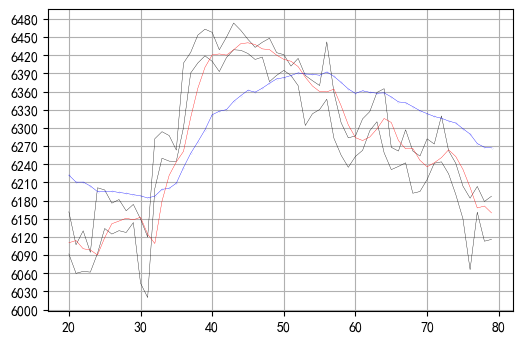

In [315]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
plt.figure()
st = 20
et = len(d1)
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*2
plt.plot(h1[0][st:et],'k',linewidth=0.25)
plt.plot(l1[0][st:et],'k',linewidth=0.25)
plt.plot(AMA_11H[0][st:et],'b.-',linewidth=0.25, markersize=0.1)
#plt.plot(AMA_21H[0][st:et],'b',linewidth=0.25)
plt.plot(AMA1H[0][st:et],'r',linewidth=0.25)
plt.grid()
y_major_locator=MultipleLocator(30)
#把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()
#ax为两条坐标轴的实例
ax.yaxis.set_major_locator(y_major_locator)
#把x轴的主刻度设置为1的倍数


In [316]:
# 将一小时的AMA上轨线 up sample至3分钟上，作为判断依据
AMA_hourH = np.zeros(dtes.shape)
AMA_hourL = np.zeros(dtes.shape)
for (i,x) in enumerate(d1):
    if i<len(d1)-1:
        idx = (dtes>=d1[i]) & (dtes<d1[i+1])
        AMA_hourH[idx] = AMA_11H[0][i]
        AMA_hourL[idx] = AMA_21H[0][i]
    else:
        idx = dtes>=d1[i]
        AMA_hourH[idx] = AMA_11H[0][i]
        AMA_hourL[idx] = AMA_21H[0][i]
        

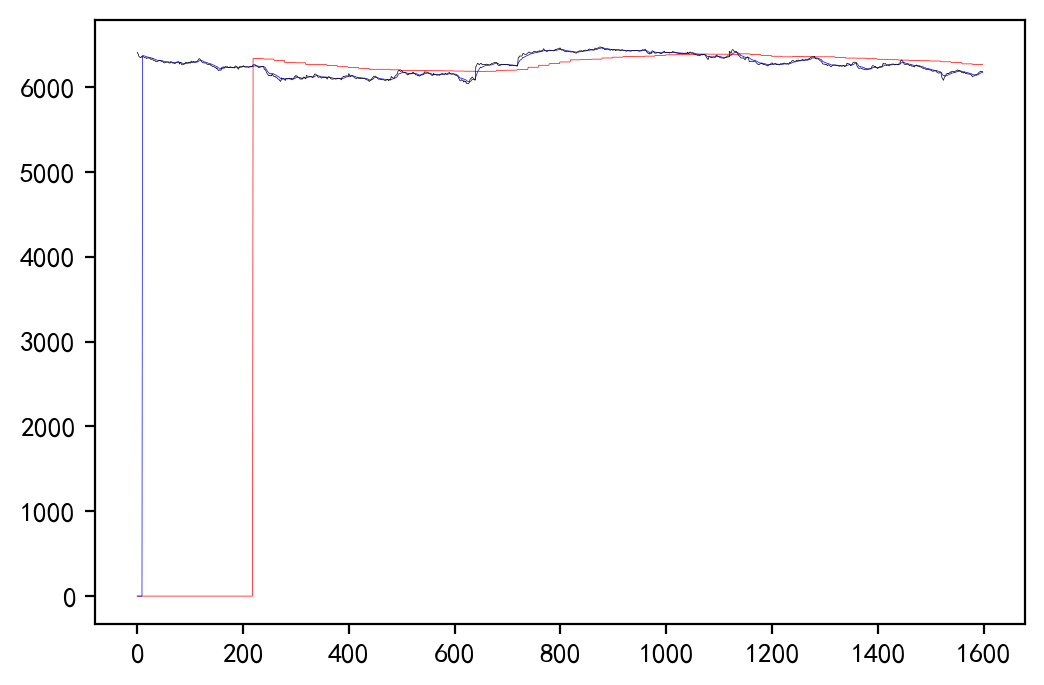

In [317]:
plt.plot(AMA_hourH[:-1],'r-',lineWidth=0.25)
plt.plot(np.array(AMA_1[0][:-1]),'b-', lineWidth=0.25)
plt.plot(np.array(high_mtx[0][:-1]),'k-', lineWidth=0.25)

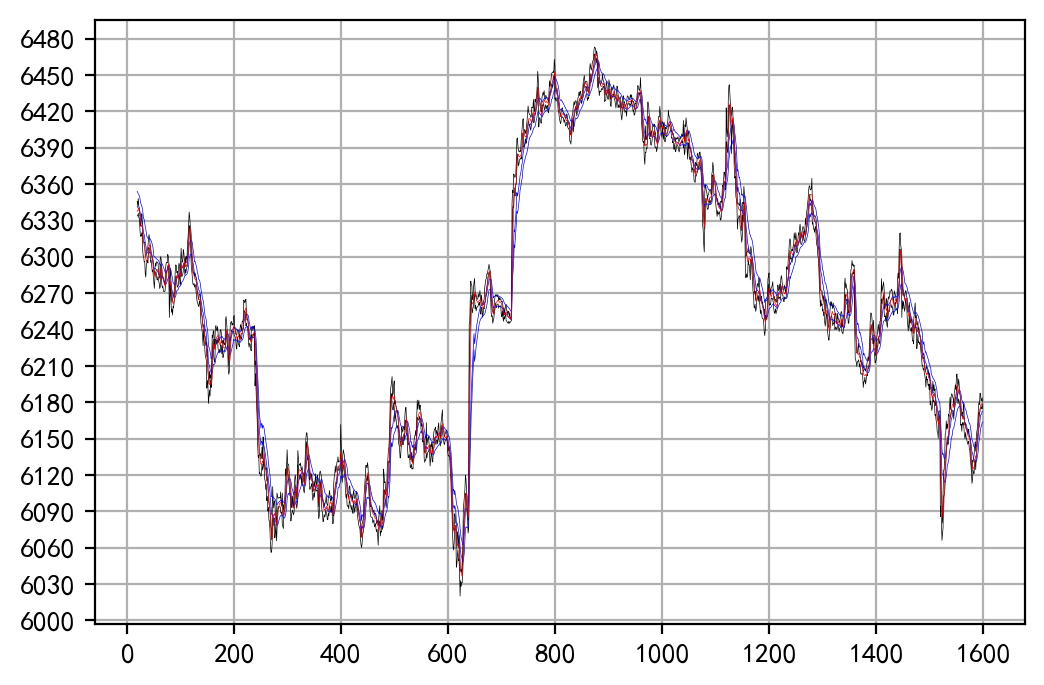

In [318]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
plt.figure()
st = 20
et = len(dtes)
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*2
plt.plot(high_mtx[0][st:et],'k',linewidth=0.25)
plt.plot(low_mtx[0][st:et],'k',linewidth=0.25)
plt.plot(AMA_1[0][st:et],'b',linewidth=0.25)
plt.plot(AMA_2[0][st:et],'b',linewidth=0.25)
plt.plot(AMA[0][st:et],'r',linewidth=0.25)
plt.grid()
y_major_locator=MultipleLocator(30)
#把y轴的刻度间隔设置为10，并存在变量里
ax=plt.gca()
#ax为两条坐标轴的实例
ax.yaxis.set_major_locator(y_major_locator)
#把x轴的主刻度设置为1的倍数


In [319]:
dtes[-1]

20201026.15

20200921.1003 6349.065118753217 6373.266101533795 6354.694700845548 AMA破下轨, 前低设定为: 6336.4  卖开点设定为: 6366.4
20200921.1024 创新低: 6335.4  更新做空价: 6365.4
20200921.1027 创新低: 6328.6  更新做空价: 6358.6
20200921.1048 创新低: 6323.4  更新做空价: 6353.4
20200921.1051 创新低: 6317.0  更新做空价: 6347.0
20200921.1103 创新低: 6307.0  更新做空价: 6337.0
20200921.1106 创新低: 6301.2  更新做空价: 6331.2
20200921.1109 创新低: 6300.6  更新做空价: 6330.6
20200921.1112 创新低: 6296.0  更新做空价: 6326.0
20200921.1118 创新低: 6286.2  更新做空价: 6316.2
20200921.1121 创新低: 6283.2  更新做空价: 6313.2
20200921.1306 到达卖出点: 6313.2
20200921.1333 到达止赢点: 6284.2
20200921.1336 创新低: 6278.6  更新做空价: 6308.6
20200921.1339 创新低: 6274.0  更新做空价: 6304.0
20200921.1409 创新低: 6273.8  更新做空价: 6303.8
20200921.143 创新低: 6271.6  更新做空价: 6301.6
20200921.1433 创新低: 6271.4  更新做空价: 6301.4
20200921.1436 创新低: 6271.2  更新做空价: 6301.2
20200921.1454 到达卖出点: 6301.2
20200922.0933 到达止赢点: 6272.2
20200922.0936 到达卖出点: 6280.0
20200922.1115 到达止损点: 6310.0
20200922.1315 6293.023576162718 6306.704540824086 6295.123331893112 AMA

20201023.1327 创新低: 6206.8  更新做空价: 6236.8
20201023.1333 创新低: 6204.0  更新做空价: 6234.0
20201023.1336 创新低: 6202.0  更新做空价: 6232.0
20201023.1339 创新低: 6198.6  更新做空价: 6228.6
20201023.1342 创新低: 6192.4  更新做空价: 6222.4
20201023.14 创新低: 6190.2  更新做空价: 6220.2
20201023.1406 创新低: 6177.8  更新做空价: 6207.8
20201023.1412 创新低: 6176.6  更新做空价: 6206.6
20201023.1415 创新低: 6173.2  更新做空价: 6203.2
20201023.1433 创新低: 6169.2  更新做空价: 6199.2
20201023.1439 创新低: 6165.0  更新做空价: 6195.0
20201023.1442 创新低: 6163.8  更新做空价: 6193.8
20201023.1445 创新低: 6156.0  更新做空价: 6186.0
20201023.1448 创新低: 6155.2  更新做空价: 6185.2
20201023.1451 创新低: 6150.2  更新做空价: 6180.2
20201026.0933 创新低: 6085.6  更新做空价: 6115.6
20201026.0939 创新低: 6080.0  更新做空价: 6110.0
20201026.0942 创新低: 6066.0  更新做空价: 6096.0
20201026.0948 到达卖出点: 6096.0
20201026.0957 到达止损点: 6126.0
20201026.1306 6167.142792252106 6181.052908119409 6169.293880746062 AMA破下轨, 前低设定为: 6156.0  卖开点设定为: 6186.0
20201026.1318 创新低: 6152.4  更新做空价: 6182.4
20201026.1321 创新低: 6149.8  更新做空价: 6179.8
20201026.133 创新低: 61

Text(0.5, 1.0, '空')

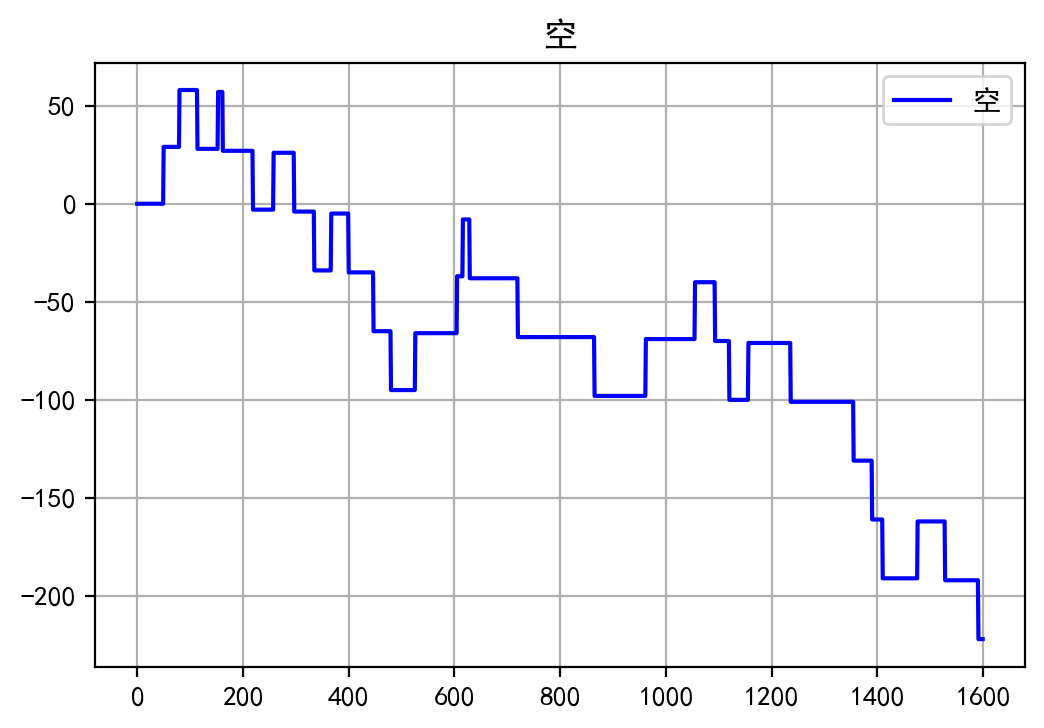

In [328]:
# 做空
sellInPrice = -1
atrW = 30
atrH = 30
atrS = 30
status = 'idle'
pnl = []
pnlShort = np.zeros(AMA_1.shape)
dtesPnl = []
AmlifyLine = 0 # 增加突破难度
for i in range(5,len(AMA[0])):
    #print(dtes[i], 'low=', np.round(low_mtx[0][i],2), ' EMA_lowM=', np.round(EMA_lowM[0][i],2), ' AMA=',np.round(AMA[0][i],2),', AMA1=',np.round(AMA_1[0][i],2), ', AMA2=',np.round(AMA_2[0][i],2), ' low_mtx=', np.round(low_mtx[0][i],2))
    #print((AMA[0][i-1]>=(AMA_2[0][i-1]+AmlifyLine)), (AMA[0][i]<(AMA_2[0][i]+AmlifyLine)),  (status=='idle'), (high_mtx[0][i]<=AMA_hourL[i]))
    #修正：破位需要前一个AMA轨道内，此AMA在轨道外
#    if (AMA[0][i-1]>=(AMA_2[0][i-1]+AmlifyLine)) & (AMA[0][i]<(AMA_2[0][i]+AmlifyLine)) & (status=='idle') & (high_mtx[0][i]<=AMA_hourL[i]):
    if (AMA[0][i-1]>=(AMA_2[0][i-1]+AmlifyLine)) & (AMA[0][i]<(AMA_2[0][i]+AmlifyLine)) & (status=='idle'):
        clow = np.min(low_mtx[0][i-4:i+1])  # 修正：使用前4根到此时的K线的最低点
        sellInPrice = clow+atrH # 如果AMA<下轨， 且处于空闲状态， 则进入等待状态，且做空价=当前K线最低价+ATRH
        status='wait'
        print(dtes[i], AMA[0][i], AMA_1[0][i], AMA_2[0][i],'AMA破下轨, 前低设定为:',clow, ' 卖开点设定为:',sellInPrice)#,' AMA=',np.round(AMA[0][i],2), ', AMA1=',np.round(AMA_1[0][i],2))
        continue
    if (status=='wait'):
        if (high_mtx[0][i]>=sellInPrice): # 如果处于等待状态，且当前K线最高价格高于做空价，则做空
            status='short'
            print(dtes[i], '到达卖出点:',sellInPrice)#, 'AMA=',np.round(AMA[0][i],2), ', AMA1=',np.round(AMA_1[0][i],2))
#            continue #修改
        if (low_mtx[0][i]+atrH)<sellInPrice: # 如果处于等待状态，还没有做空，且创新低，则更新做空价=当前最低价+ATRH
            sellInPrice=low_mtx[0][i]+atrH
            print(dtes[i], '创新低:',low_mtx[0][i],' 更新做空价:',sellInPrice)#', AMA=',AMA[0][i], ', AMA1=',AMA_1[0][i])
#            continue #修改
    if (status=='short'):
        if (high_mtx[0][i]>=sellInPrice+atrS): # 最高价高于卖出价+ATRS，说明止损
            profit = -atrS
            pnl.append(profit)
            pnlShort[i] = profit
            print(dtes[i],'到达止损点:',sellInPrice+atrS)
            dtesPnl.append(dtes[i])
            status='idle'
#            continue #修改
        if (low_mtx[0][i]<=sellInPrice-atrW+1): # 最低价低于卖出价-ATRW， 说明止盈
            profit = atrW-1
            pnl.append(profit)
            pnlShort[i] = profit
            dtesPnl.append(dtes[i])
            print(dtes[i],'到达止赢点:',sellInPrice-atrW+1)
            status='wait'
            sellInPrice = low_mtx[0][i]+atrH #修改
#            continue #修改
        
plt.plot(np.cumsum(pnlShort), 'b')
plt.grid()
plt.legend(['空'])
plt.title('空')        

20200921.1454 6290.673231758328 6290.63262481063 6281.590497456512 AMA破上轨, 前高设定为: 6302.0  买入点设定为: 6272.0
20200922.0933 到达买入点: 6272.0
20200922.1039 到达止赢点: 6301.0
20200922.1115 创新高: 6312.0  更新买入价: 6282.0
20200922.1118 创新高: 6316.4  更新买入价: 6286.4
20200922.1121 创新高: 6326.4  更新买入价: 6296.4
20200922.1124 创新高: 6337.0  更新买入价: 6307.0
20200922.1303 到达买入点: 6307.0
20200922.1318 到达止损点: 6277.0
20200923.0939 6223.303822451195 6223.142261190409 6211.177932155002 AMA破上轨, 前高设定为: 6239.0  买入点设定为: 6209.0
20200923.0951 创新高: 6241.8  更新买入价: 6211.8
20200923.0954 创新高: 6243.4  更新买入价: 6213.4
20200923.1048 创新高: 6248.2  更新买入价: 6218.2
20200923.1051 创新高: 6250.8  更新买入价: 6220.8
20200923.1103 到达买入点: 6220.8
20200923.1303 到达止赢点: 6249.8
20200923.1306 创新高: 6251.6  更新买入价: 6221.6
20200923.14 创新高: 6264.4  更新买入价: 6234.4
20200923.1412 创新高: 6265.0  更新买入价: 6235.0
20200923.1427 到达买入点: 6235.0
20200924.0933 到达止损点: 6205.0
20200924.1357 6104.365602724942 6102.96412481503 6089.88146406347 AMA破上轨, 前高设定为: 6125.0  买入点设定为: 6095.0
20200924.14 

Text(0.5, 1.0, '多')

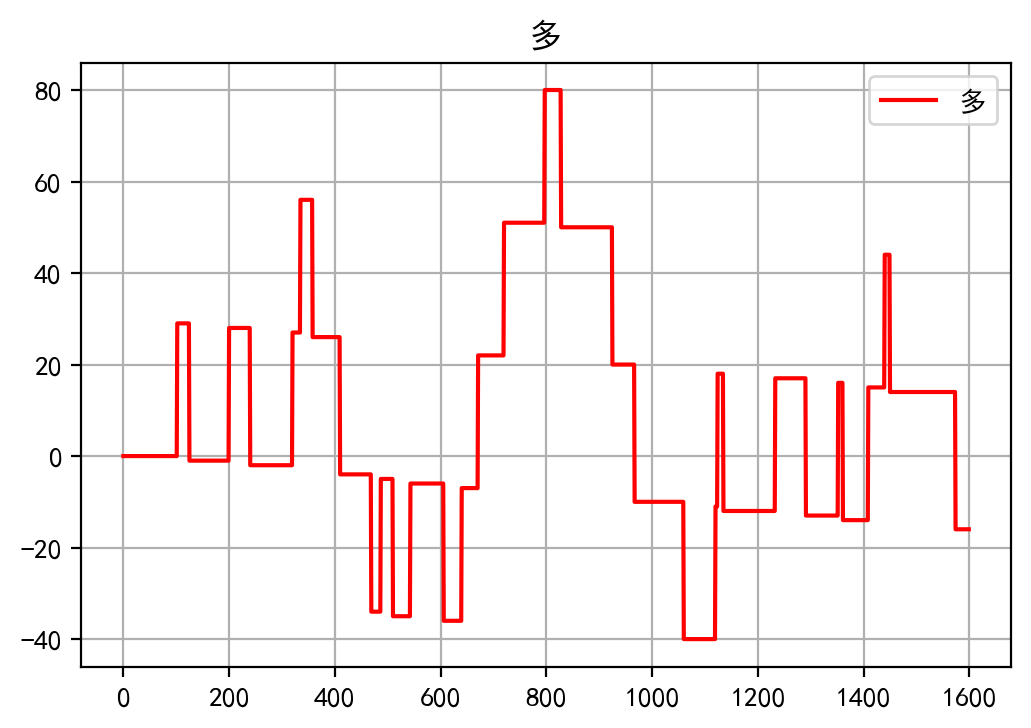

In [340]:
# 1. 修正continue
# 2. 增加
# 做多
buyInPrice = -1
atrW = 30
atrH = 30
atrS = 30
status = 'idle'
pnl = []
pnlLong = np.zeros(AMA_1.shape)
dtesPnl = []
AmlifyLine = 0 # 增加突破难度
for i in range(5, len(AMA[0])):
#    print(dtes[i],' AMA=',np.round(AMA[0][i],2),', AMA1=',np.round(AMA_1[0][i],2), ', AMA2=',np.round(AMA_2[0][i],2), ' low_mtx=', np.round(low_mtx[0][i],2))
#    if (AMA[0][i-1]<=(AMA_1[0][i]+AmlifyLine))&(AMA[0][i]>AMA_2[0][i]+AmlifyLine))&(status=='idle')&(low_mtx[0][i]>=AMA_hourH[i]):
    if (AMA[0][i-1]<=(AMA_1[0][i]+AmlifyLine))&(AMA[0][i]>AMA_1[0][i]+AmlifyLine)&(status=='idle'):
        chigh = np.max(high_mtx[0][i-4:i+1])
        buyInPrice = chigh-atrH # 如果AMA>上轨， 且处于空闲状态， 则进入等待状态，且买入价=当前K线最高价-ATRH
        status='wait'
        print(dtes[i], AMA[0][i], AMA_1[0][i], AMA_2[0][i], 'AMA破上轨, 前高设定为:',chigh, ' 买入点设定为:',buyInPrice)#,' AMA=',np.round(AMA[0][i],2), ', AMA2=',np.round(AMA_2[0][i],2))
        continue # 修改
    if (status=='wait'): 
        if (low_mtx[0][i]<=buyInPrice): # 如果处于等待状态，且当前K线最低价格低于买入价，则买入
            status='long'
            print(dtes[i], '到达买入点:',buyInPrice)#, 'AMA=',np.round(AMA[0][i],2), ', AMA1=',np.round(AMA_1[0][i],2))
            continue #修改
        if (high_mtx[0][i]-atrH)>buyInPrice: # 如果处于等待状态，还没有买入，且创新高，则更新买入价=当前最高价-ATRH
            buyInPrice=high_mtx[0][i]-atrH
            print(dtes[i], '创新高:',high_mtx[0][i],' 更新买入价:',buyInPrice)#', AMA=',AMA[0][i], ', AMA1=',AMA_1[0][i])
            continue #修改
    if (status=='long'):
        if (low_mtx[0][i]<=buyInPrice-atrS): # 最低价小于买入价-ATRS，说明止损
            profit = -atrS
            pnl.append(profit)
            pnlLong[i] = profit
            print(dtes[i],'到达止损点:',buyInPrice-atrS)
            dtesPnl.append(dtes[i])
            status='idle'
            continue #修改
        if (high_mtx[0][i]>=buyInPrice+atrW-1): # 最高价高于买入价+ATRW， 说明止盈
            profit = atrW-1
            pnl.append(profit)
            pnlLong[i] = profit
            dtesPnl.append(dtes[i])
            print(dtes[i],'到达止赢点:',buyInPrice+atrW-1)
            status='wait'  #修改
            buyInPrice = high_mtx[0][i]-atrH #修改
            continue #修改
        
plt.plot(np.cumsum(pnlLong),'r')
plt.grid()
plt.legend(['多'])
plt.title('多')
        

In [329]:
print(list(dtes))

[20200921.0933, 20200921.0936, 20200921.0939, 20200921.0942, 20200921.0945, 20200921.0948, 20200921.0951, 20200921.0954, 20200921.0957, 20200921.1, 20200921.1003, 20200921.1006, 20200921.1009, 20200921.1012, 20200921.1015, 20200921.1018, 20200921.1021, 20200921.1024, 20200921.1027, 20200921.103, 20200921.1033, 20200921.1036, 20200921.1039, 20200921.1042, 20200921.1045, 20200921.1048, 20200921.1051, 20200921.1054, 20200921.1057, 20200921.11, 20200921.1103, 20200921.1106, 20200921.1109, 20200921.1112, 20200921.1115, 20200921.1118, 20200921.1121, 20200921.1124, 20200921.1127, 20200921.113, 20200921.1303, 20200921.1306, 20200921.1309, 20200921.1312, 20200921.1315, 20200921.1318, 20200921.1321, 20200921.1324, 20200921.1327, 20200921.133, 20200921.1333, 20200921.1336, 20200921.1339, 20200921.1342, 20200921.1345, 20200921.1348, 20200921.1351, 20200921.1354, 20200921.1357, 20200921.14, 20200921.1403, 20200921.1406, 20200921.1409, 20200921.1412, 20200921.1415, 20200921.1418, 20200921.1421, 2020

Text(0.5, 1.0, '多+空')

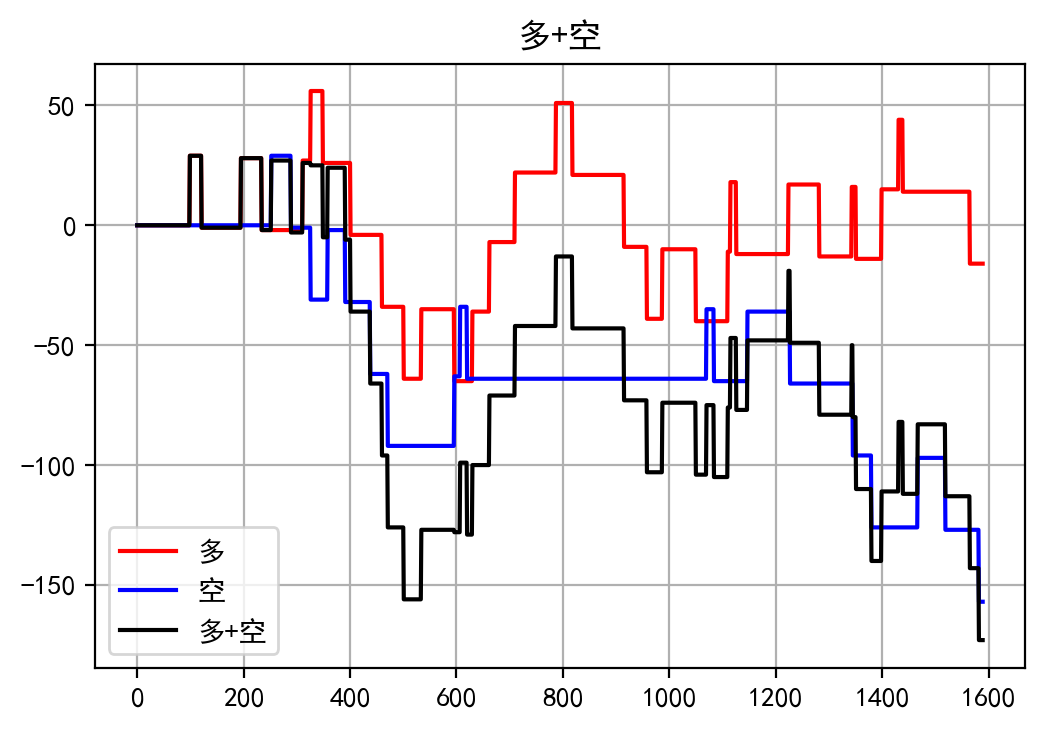

In [171]:
plt.plot(np.cumsum(pnlLong),'r')
plt.plot(np.cumsum(pnlShort), 'b')
plt.plot(np.cumsum(pnlLong+pnlShort),'k')
plt.grid()
plt.legend(['多','空','多+空'])
plt.title('多+空')

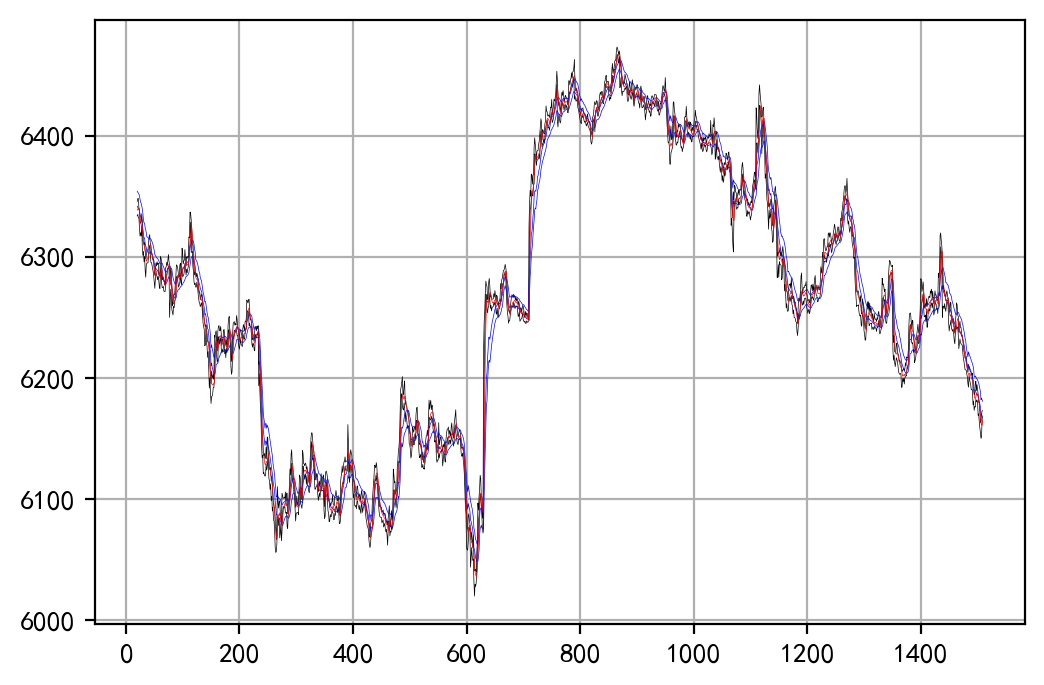

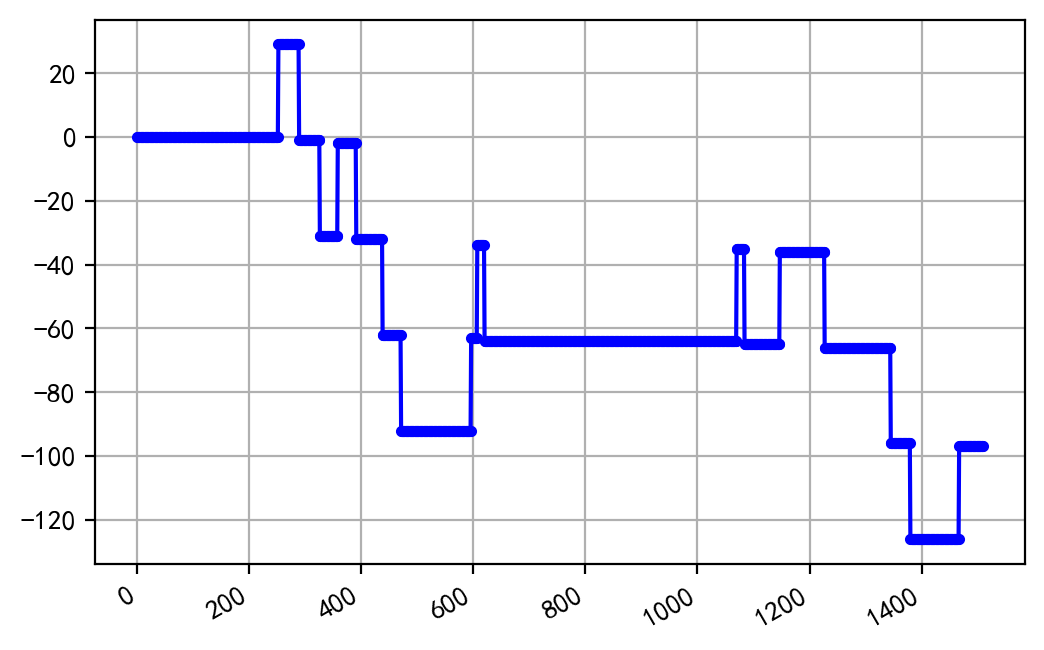

In [152]:
#for (i,x) in enumerate(dtesPnl):
#    print(x, pnl[i])
plt.figure()
st = 20
et = len(dtes)
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*2
plt.plot(high_mtx[0][st:et],'k',linewidth=0.25)
plt.plot(low_mtx[0][st:et],'k',linewidth=0.25)
plt.plot(AMA_1[0][st:et],'b',linewidth=0.25)
plt.plot(AMA_2[0][st:et],'b',linewidth=0.25)
plt.plot(AMA[0][st:et],'r',linewidth=0.25)
plt.grid()
def dtes2Label(dtes):
    return np.array([datetime.strptime(str(int(np.floor(d))), '%Y%m%d').date() for d in dtes])
plt.figure()
plt.plot(np.cumsum(pnlShort),'b.-')
#plt.plot(np.cumsum(pnl),'b-')
plt.gcf().autofmt_xdate()  # 自动旋转日期标记
plt.grid()

In [153]:
AMA_hour[AMA_hour==0]= AMA_hour[1000]
AMA_1[0][AMA_1[0]==0]=AMA_1[0][1000]
AMA_hourL[AMA_hourL==0]= AMA_hourL[1000]
AMA_2[0][AMA_2[0]==0]=AMA_2[0][1000]


NameError: name 'AMA_hour' is not defined

In [ ]:
pnl2=pnl2.flatten()

In [ ]:
idx1 = np.nonzero(pnl2>0)[0]
idx2 = np.nonzero(pnl2<0)[0]
k = np.array(range(len(pnl2)))


In [ ]:
plt.plot(np.cumsum(pnl2))

In [ ]:
plt.plot(AMA_hourL,'r-', lineWidth=0.25)
plt.plot(np.array(AMA_2[0]),'b-', lineWidth=0.25)
plt.scatter(k[idx1], AMA_hourL[idx1],s=0.25,c='red')
plt.scatter(k[idx2], AMA_hourL[idx2],s=0.25,c='green')
plt.grid()

In [ ]:
dtes